#  Segmentation by Nationality in Neighbourhoods in Barcelona

## 1. Introduction

XXXX

## 2. Data

### 2.1 Sources used in the project
xxxx

### 2.2 Analyze and visualiza data for the analysis

####  Import libraries

In [1]:
import pandas as pd
import numpy as np

import json

import unidecode

import folium

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans 
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import euclidean_distances

import os
import time
from selenium import webdriver

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

from PIL import Image # converting images into arrays

#### a) Administrative Divisions in 2010 from Carto BCN 

We have decided to use data from cartographic department of Barcelona Town Council with information of districts and neoghbourhoods, their shapes and boundaries. They can be downloaded for free from https://w20.bcn.cat/cartobcn/default.aspx?lang=en by creating a free account in ESRI format.<br>
<br>
ESRI format contains a shapefile (shp) which contains the shapes in vectorial format of the different neighbourhoods and districs of the city, and a database file (dfx) which contain some statistical data of every neighbourhood. They can be easily read with the Python library pyshp (https://pypi.org/project/pyshp/) <br>
<br>
The database contains the following fields: <br>
o District: District code  <br>
o NDistric: District name  <br>
o CBarri: Neighbourhood code  <br>
o NBarri: neighbourhood name  <br>
o Homes: Number of men  <br>
o Dones: Number of women. <br>
o Perimetr: Perimiter <br>
o Area: Surface in square meters  <br>
o Coord_X: X-axis centroid coordinates, in UTM format<br>
o Coord_Y: Y-axis centroid coordinates, in UTM format<br>
o Web1: Link to district's web page  <br>
o Web2: Link to city's annual stats  <br>
o Web3: Link to districts's annual stats  <br>
o Web4: Link to neoighboourhood's annual stats  <br>
<br>
A shapefile file with vectorial information of neighbourhood boundaries will be used to create city maps with Cloropeth library and Coord_X and Coord_Y files, as they define of the centroid of each neighbourhood, will be used to make queries with Foursquare API. However downloaded data use UTM format, and we need to convert it to GPS coordenates. Therefore we are going to transform the files.

Define define input and ouput filename parameters

In [2]:
processed_neighbourhood_jsonfile = 'processed_data/BCN_Barri_ED50_SHP.json'    

In [3]:
with open(processed_neighbourhood_jsonfile, 'r') as f:
    geojson  = json.load(f)

neigh_list= []
for row in geojson ['features']:
    neigh_record = {}
    neigh_record['C_Dist']= row['properties']['C_Dist']
    neigh_record['N_Dist']= row['properties']['N_Dist']
    neigh_record['C_Neigh']= row['properties']['C_Neigh']
    neigh_record['N_Neigh']= row['properties']['N_Neigh']
    neigh_record['Latitude']= row['properties']['Latitude']
    neigh_record['Longitude']= row['properties']['Longitude']
    neigh_list.append(neigh_record)

df_neigh_coord = pd.DataFrame(neigh_list) 
df_neigh_coord.head()

,C_Dist,C_Neigh,Latitude,Longitude,N_Dist,N_Neigh
0,01,01,41.37896,2.170491,Ciutat Vella,el Raval
1,01,02,41.38109,2.177446,Ciutat Vella,el Barri Gotic
2,01,03,41.37720,2.190158,Ciutat Vella,la Barceloneta
3,01,04,41.38679,2.183436,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera"
4,02,05,41.39741,2.181486,Eixample,el Fort Pienc


In [4]:
#df_price_coord= df_house_price.merge(pd.DataFrame(poly_list), how= 'left', on= 'Barrio Id')
#df_price_coord[:6]

We can examine the neighbourhoods in a map using folium library

In [5]:
bcn_geo = processed_neighbourhood_jsonfile # geojson file

# Barcelona latitude and longitude values
latitude = 41.396
longitude = 2.1774322

# create map 
bcn_map = folium.Map(location=[latitude, longitude], zoom_start=12)
    
#add a Choropleth layer  
bcn_geo = bcn_geo # geojson file
folium.Choropleth(geo_data=bcn_geo).add_to(bcn_map)

# add markers of the centroids to the map
for lat, lon, poi in zip(df_neigh_coord['Latitude'], df_neigh_coord['Longitude'], df_neigh_coord['N_Neigh']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.Marker(
        [lat, lon],
        popup= label
        ).add_to(bcn_map)
    
    
folium.LayerControl().add_to(bcn_map)    

#save the map 
delay=5
fn= 'outputs/maps/barcelona/bcn_neighbourhoods.html'
tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
bcn_map.save(fn)

browser = webdriver.Chrome()
browser.set_window_size(860, 750)
browser.get(tmpurl)
#Give the map tiles some time to load
time.sleep(delay)
browser.save_screenshot('outputs/maps/barcelona/bcn_neighbourhoods.png')
browser.quit()

# display map
bcn_map

#### b) Official population's nationality by neighbourhood classified by genre of the city of Barcelona

https://opendata-ajuntament.barcelona.cat/data/dataset/est-ine-nacionalitat

In [6]:
raw_nationalities_file = 'src/2017_ine_nacionalitat_per_sexe.csv'
bcn_nationalities_df = pd.read_csv(raw_nationalities_file, dtype = {"Codi_Districte" : "str", "Codi_Barri" : "str", "Nombre" : "float64" })

bcn_nationalities_df.rename(columns={"Any": "Year", "Codi_Districte": "C_Dist",  "Nom_Districte": "N_Dist", 
                                  "Codi_Barri": "C_Neigh", "Nom_Barri": "N_Neigh", "Valor": "Value", "Nacionalitat" : "Nationality", "Nombre" : "Number"}, inplace = True)

#Change numerical codes to string codes in order they match with other datasets
bcn_nationalities_df['C_Dist'].replace('1','01', inplace=True)
bcn_nationalities_df['C_Dist'].replace('2','02', inplace=True)
bcn_nationalities_df['C_Dist'].replace('3','03', inplace=True)
bcn_nationalities_df['C_Dist'].replace('4','04', inplace=True)
bcn_nationalities_df['C_Dist'].replace('5','05', inplace=True)
bcn_nationalities_df['C_Dist'].replace('6','06', inplace=True)
bcn_nationalities_df['C_Dist'].replace('7','07', inplace=True)
bcn_nationalities_df['C_Dist'].replace('8','08', inplace=True)
bcn_nationalities_df['C_Dist'].replace('9','09', inplace=True)
bcn_nationalities_df['C_Neigh'].replace('1','01', inplace=True)
bcn_nationalities_df['C_Neigh'].replace('2','02', inplace=True)
bcn_nationalities_df['C_Neigh'].replace('3','03', inplace=True)
bcn_nationalities_df['C_Neigh'].replace('4','04', inplace=True)
bcn_nationalities_df['C_Neigh'].replace('5','05', inplace=True)
bcn_nationalities_df['C_Neigh'].replace('6','06', inplace=True)
bcn_nationalities_df['C_Neigh'].replace('7','07', inplace=True)
bcn_nationalities_df['C_Neigh'].replace('8','08', inplace=True)
bcn_nationalities_df['C_Neigh'].replace('9','09', inplace=True)

#Change country names from Catalan to English
bcn_nationalities_df['Nationality'].replace('Afganistan','Afganistan', inplace=True)
bcn_nationalities_df['Nationality'].replace('Albània','Albania', inplace=True)
bcn_nationalities_df['Nationality'].replace('Alemanya','Germany', inplace=True)
bcn_nationalities_df['Nationality'].replace('Algèria','Algeria', inplace=True)
bcn_nationalities_df['Nationality'].replace("Altres països o  territoris d'Àsia",'Other_countries_of_Asia', inplace=True)
bcn_nationalities_df['Nationality'].replace("Altres països o territoris d'Amèrica",'Other_countries_of_America', inplace=True)
bcn_nationalities_df['Nationality'].replace("Altres països o territoris d'Europa",'Other_countries_of_Europe', inplace=True)
bcn_nationalities_df['Nationality'].replace("Altres països o territoris d'Àfrica",'Other_countries_of_Africa', inplace=True)
bcn_nationalities_df['Nationality'].replace('Andorra','Andorra', inplace=True)
bcn_nationalities_df['Nationality'].replace('Angola','Angola', inplace=True)
bcn_nationalities_df['Nationality'].replace('Apàtrides','Stateless', inplace=True)
bcn_nationalities_df['Nationality'].replace('Argentina','Argentina', inplace=True)
bcn_nationalities_df['Nationality'].replace('Armènia','Armenia', inplace=True)
bcn_nationalities_df['Nationality'].replace('Aràbia Saudí','Saudi Arabia', inplace=True)
bcn_nationalities_df['Nationality'].replace('Austràlia','Australia', inplace=True)
bcn_nationalities_df['Nationality'].replace('Azerbaidjan','Azerbaidjan', inplace=True)
bcn_nationalities_df['Nationality'].replace('Bahames, les','Bahamas', inplace=True)
bcn_nationalities_df['Nationality'].replace('Bahrain','Bahrain', inplace=True)
bcn_nationalities_df['Nationality'].replace('Bangladesh','Bangladesh', inplace=True)
bcn_nationalities_df['Nationality'].replace('Barbados','Barbados', inplace=True)
bcn_nationalities_df['Nationality'].replace('Belarús','Belarus', inplace=True)
bcn_nationalities_df['Nationality'].replace('Benín','Benin', inplace=True)
bcn_nationalities_df['Nationality'].replace('Bolívia','Bolivia', inplace=True)
bcn_nationalities_df['Nationality'].replace('Botswana','Botswana', inplace=True)
bcn_nationalities_df['Nationality'].replace('Brasil','Brasil', inplace=True)
bcn_nationalities_df['Nationality'].replace('Bulgària','Bulgaria', inplace=True)
bcn_nationalities_df['Nationality'].replace('Burkina Faso','Burkina Faso', inplace=True)
bcn_nationalities_df['Nationality'].replace('Burundi','Burundi', inplace=True)
bcn_nationalities_df['Nationality'].replace('Bèlgica','Belgium', inplace=True)
bcn_nationalities_df['Nationality'].replace('Bòsnia i Hercegovina','Bosnia_Herzegovina', inplace=True)
bcn_nationalities_df['Nationality'].replace('Cambodja','Cambodja', inplace=True)
bcn_nationalities_df['Nationality'].replace('Camerun','Cameroon', inplace=True)
bcn_nationalities_df['Nationality'].replace('Canadà','Canada', inplace=True)
bcn_nationalities_df['Nationality'].replace('Cap Verd','Cape Verde', inplace=True)
bcn_nationalities_df['Nationality'].replace('Colòmbia','Colombia', inplace=True)
bcn_nationalities_df['Nationality'].replace('Congo','Congo', inplace=True)
bcn_nationalities_df['Nationality'].replace('Corea del Sud','South Korea', inplace=True)
bcn_nationalities_df['Nationality'].replace('Costa Rica','Costa Rica', inplace=True)
bcn_nationalities_df['Nationality'].replace("Costa d'Ivori",'Ivory Coast', inplace=True)
bcn_nationalities_df['Nationality'].replace('Croàcia','Croatia', inplace=True)
bcn_nationalities_df['Nationality'].replace('Cuba','Cuba', inplace=True)
bcn_nationalities_df['Nationality'].replace('Dinamarca','Denmark', inplace=True)
bcn_nationalities_df['Nationality'].replace('Djibouti','Djibouti', inplace=True)
bcn_nationalities_df['Nationality'].replace('Dominica','Dominica', inplace=True)
bcn_nationalities_df['Nationality'].replace('Egipte','Egypt', inplace=True)
bcn_nationalities_df['Nationality'].replace('El Salvador','El_Salvador', inplace=True)
bcn_nationalities_df['Nationality'].replace('Emirats Àrabs Units, els','United_Arab_Emirates', inplace=True)
bcn_nationalities_df['Nationality'].replace('Equador','Ecuador', inplace=True)
bcn_nationalities_df['Nationality'].replace('Eritrea','Eritrea', inplace=True)
bcn_nationalities_df['Nationality'].replace('Eslovàquia','Slovakia', inplace=True)
bcn_nationalities_df['Nationality'].replace('Eslovènia','Slovenia', inplace=True)
bcn_nationalities_df['Nationality'].replace('Espanya','Spain', inplace=True)
bcn_nationalities_df['Nationality'].replace('Estats Units, els','United_States_of_America', inplace=True)
bcn_nationalities_df['Nationality'].replace('Estònia','Estonia', inplace=True)
bcn_nationalities_df['Nationality'].replace('Etiòpia','Ethiopia', inplace=True)
bcn_nationalities_df['Nationality'].replace('Filipines','Philippines', inplace=True)
bcn_nationalities_df['Nationality'].replace('Finlàndia','Finland', inplace=True)
bcn_nationalities_df['Nationality'].replace('França','France', inplace=True)
bcn_nationalities_df['Nationality'].replace('Gabon','Gabon', inplace=True)
bcn_nationalities_df['Nationality'].replace('Geòrgia','Georgia', inplace=True)
bcn_nationalities_df['Nationality'].replace('Ghana','Ghana', inplace=True)
bcn_nationalities_df['Nationality'].replace('Grenada','Grenada', inplace=True)
bcn_nationalities_df['Nationality'].replace('Grècia','Greece', inplace=True)
bcn_nationalities_df['Nationality'].replace('Guatemala','Guatemala', inplace=True)
bcn_nationalities_df['Nationality'].replace('Guinea','Guinea', inplace=True)
bcn_nationalities_df['Nationality'].replace('Guinea Equatorial','Equatorial_Guinea', inplace=True)
bcn_nationalities_df['Nationality'].replace('Guinea-Bissau','Guinea-Bissau', inplace=True)
bcn_nationalities_df['Nationality'].replace('Guyana','Guyana', inplace=True)
bcn_nationalities_df['Nationality'].replace('Gàmbia','Gambia', inplace=True)
bcn_nationalities_df['Nationality'].replace('Haití','Haiti', inplace=True)
bcn_nationalities_df['Nationality'].replace('Hondures','Honduras', inplace=True)
bcn_nationalities_df['Nationality'].replace('Hongria','Hungary', inplace=True)
bcn_nationalities_df['Nationality'].replace('Iemen, el','Yemen', inplace=True)
bcn_nationalities_df['Nationality'].replace('Indonèsia','Indonesia', inplace=True)
bcn_nationalities_df['Nationality'].replace('Iran','Iran', inplace=True)
bcn_nationalities_df['Nationality'].replace("Iraq, l'",'Irak', inplace=True)
bcn_nationalities_df['Nationality'].replace('Irlanda','Ireland', inplace=True)
bcn_nationalities_df['Nationality'].replace('Islàndia','Iceland', inplace=True)
bcn_nationalities_df['Nationality'].replace('Israel','Israel', inplace=True)
bcn_nationalities_df['Nationality'].replace('Itàlia','Italy', inplace=True)
bcn_nationalities_df['Nationality'].replace('Jamaica','Jamaica', inplace=True)
bcn_nationalities_df['Nationality'].replace('Japó','Japan', inplace=True)
bcn_nationalities_df['Nationality'].replace('Jordània','Jordania', inplace=True)
bcn_nationalities_df['Nationality'].replace('Kazakhstan','Kazakhstan', inplace=True)
bcn_nationalities_df['Nationality'].replace('Kenya','Kenya', inplace=True)
bcn_nationalities_df['Nationality'].replace('Kirguizstan','Kirguiztan', inplace=True)
bcn_nationalities_df['Nationality'].replace('Kuwait','Kuwait', inplace=True)
bcn_nationalities_df['Nationality'].replace('Lao','Laos', inplace=True)
bcn_nationalities_df['Nationality'].replace('Lesotho','Lesotho', inplace=True)
bcn_nationalities_df['Nationality'].replace('Letònia','Latvia', inplace=True)
bcn_nationalities_df['Nationality'].replace('Libèria','Liberia', inplace=True)
bcn_nationalities_df['Nationality'].replace('Liechtenstein','Liechtenstein', inplace=True)
bcn_nationalities_df['Nationality'].replace('Lituània','Lithuania', inplace=True)
bcn_nationalities_df['Nationality'].replace('Luxemburg','Luxembourg', inplace=True)
bcn_nationalities_df['Nationality'].replace('Líban','Libanon', inplace=True)
bcn_nationalities_df['Nationality'].replace('Líbia','Libya', inplace=True)
bcn_nationalities_df['Nationality'].replace('Macedònia','Macedonia', inplace=True)
bcn_nationalities_df['Nationality'].replace('Madagascar','Madagascar', inplace=True)
bcn_nationalities_df['Nationality'].replace('Malawi','Malawi', inplace=True)
bcn_nationalities_df['Nationality'].replace('Maldives','Maldives', inplace=True)
bcn_nationalities_df['Nationality'].replace('Mali','Mali', inplace=True)
bcn_nationalities_df['Nationality'].replace('Malta','Malta', inplace=True)
bcn_nationalities_df['Nationality'].replace('Malàisia','Malaisia', inplace=True)
bcn_nationalities_df['Nationality'].replace('Marroc, el','Morocco', inplace=True)
bcn_nationalities_df['Nationality'].replace('Maurici','Mauritius', inplace=True)
bcn_nationalities_df['Nationality'].replace('Mauritània','Mauritania', inplace=True)
bcn_nationalities_df['Nationality'].replace('Moldàvia','Moldova', inplace=True)
bcn_nationalities_df['Nationality'].replace('Mongòlia','Mongolia', inplace=True)
bcn_nationalities_df['Nationality'].replace('Montenegro','Montenegro', inplace=True)
bcn_nationalities_df['Nationality'].replace('Moçambic','Mozambique', inplace=True)
bcn_nationalities_df['Nationality'].replace('Myanmar','Myanmar', inplace=True)
bcn_nationalities_df['Nationality'].replace('Mèxic','Mexico', inplace=True)
bcn_nationalities_df['Nationality'].replace('Mònaco','Monaco', inplace=True)
bcn_nationalities_df['Nationality'].replace('Namíbia','Namibia', inplace=True)
bcn_nationalities_df['Nationality'].replace('Nepal','Nepal', inplace=True)
bcn_nationalities_df['Nationality'].replace('Nicaragua','Nicaragua', inplace=True)
bcn_nationalities_df['Nationality'].replace('Nigèria','Nigeria', inplace=True)
bcn_nationalities_df['Nationality'].replace('Noruega','Norway', inplace=True)
bcn_nationalities_df['Nationality'].replace('Nova Zelanda','New Zealand', inplace=True)
bcn_nationalities_df['Nationality'].replace('Níger','Nigeria', inplace=True)
bcn_nationalities_df['Nationality'].replace('Oman','Oman', inplace=True)
bcn_nationalities_df['Nationality'].replace('Pakistan','Pakistan', inplace=True)
bcn_nationalities_df['Nationality'].replace('Panamà','Panama', inplace=True)
bcn_nationalities_df['Nationality'].replace('Paraguai','Paraguay', inplace=True)
bcn_nationalities_df['Nationality'].replace('Països Baixos','Netherlands', inplace=True)
bcn_nationalities_df['Nationality'].replace('Perú','Peru', inplace=True)
bcn_nationalities_df['Nationality'].replace('Polònia','Poland', inplace=True)
bcn_nationalities_df['Nationality'].replace('Portugal','Portugal', inplace=True)
bcn_nationalities_df['Nationality'].replace('Qatar','Qatar', inplace=True)
bcn_nationalities_df['Nationality'].replace('Regne Unit','United Kingdom', inplace=True)
bcn_nationalities_df['Nationality'].replace('República Centreafricana','Central_Africa_Republic', inplace=True)
bcn_nationalities_df['Nationality'].replace('República Democràtica del Congo','Congo_Democratic_Republic', inplace=True)
bcn_nationalities_df['Nationality'].replace('República Dominicana','Dominican_Republic', inplace=True)
bcn_nationalities_df['Nationality'].replace('Romania','Romania', inplace=True)
bcn_nationalities_df['Nationality'].replace('Ruanda','Rwanda', inplace=True)
bcn_nationalities_df['Nationality'].replace('Rússia','Russia', inplace=True)
bcn_nationalities_df['Nationality'].replace('Saint Kitts i Nevis','Saint Kitts and Nevis', inplace=True)
bcn_nationalities_df['Nationality'].replace('San Marino','San Marino', inplace=True)
bcn_nationalities_df['Nationality'].replace('Senegal','Senegal', inplace=True)
bcn_nationalities_df['Nationality'].replace('Seychelles','Seychelles', inplace=True)
bcn_nationalities_df['Nationality'].replace('Sierra Leone','Sierra Leone', inplace=True)
bcn_nationalities_df['Nationality'].replace('Singapur','Singapore', inplace=True)
bcn_nationalities_df['Nationality'].replace('Somàlia','Somalia', inplace=True)
bcn_nationalities_df['Nationality'].replace('Sri Lanka','Sri Lanka', inplace=True)
bcn_nationalities_df['Nationality'].replace('Sud-àfrica','South-Africa', inplace=True)
bcn_nationalities_df['Nationality'].replace('Sudan, el','Sudan', inplace=True)
bcn_nationalities_df['Nationality'].replace('Surinam','Surinam', inplace=True)
bcn_nationalities_df['Nationality'].replace('Suècia','Sweden', inplace=True)
bcn_nationalities_df['Nationality'].replace('Suïssa','Switzerland', inplace=True)
bcn_nationalities_df['Nationality'].replace('Swaziland','Swaziland', inplace=True)
bcn_nationalities_df['Nationality'].replace('São Tomé i Príncipe','Sao Tome and Principe', inplace=True)
bcn_nationalities_df['Nationality'].replace('Sèrbia','Serbia', inplace=True)
bcn_nationalities_df['Nationality'].replace('Síria','Siria', inplace=True)
bcn_nationalities_df['Nationality'].replace('Tadjikistan','Tadjikistan', inplace=True)
bcn_nationalities_df['Nationality'].replace('Tailàndia','Thailand', inplace=True)
bcn_nationalities_df['Nationality'].replace('Tanzània','Tanzania', inplace=True)
bcn_nationalities_df['Nationality'].replace('Territoris Palestins','Palestina', inplace=True)
bcn_nationalities_df['Nationality'].replace('Timor-Leste','East-Timor', inplace=True)
bcn_nationalities_df['Nationality'].replace('Togo','Togo', inplace=True)
bcn_nationalities_df['Nationality'].replace('Trinidad i Tobago','Trinidad and Tobago', inplace=True)
bcn_nationalities_df['Nationality'].replace('Tunísia','Tunidia', inplace=True)
bcn_nationalities_df['Nationality'].replace('Turkmenistan','Turkmenistan', inplace=True)
bcn_nationalities_df['Nationality'].replace('Turquia','Turkey', inplace=True)
bcn_nationalities_df['Nationality'].replace('Txad','Chad', inplace=True)
bcn_nationalities_df['Nationality'].replace('Txèquia','Czech_Republic', inplace=True)
bcn_nationalities_df['Nationality'].replace('Ucraïna','Ukraine', inplace=True)
bcn_nationalities_df['Nationality'].replace('Uganda','Uganda', inplace=True)
bcn_nationalities_df['Nationality'].replace('Uruguai','Uruguay', inplace=True)
bcn_nationalities_df['Nationality'].replace('Uzbekistan','Uzbekistan', inplace=True)
bcn_nationalities_df['Nationality'].replace('Veneçuela','Venezuela', inplace=True)
bcn_nationalities_df['Nationality'].replace('Vietnam','Vietnam', inplace=True)
bcn_nationalities_df['Nationality'].replace('Xile','Chile', inplace=True)
bcn_nationalities_df['Nationality'].replace('Xina','China', inplace=True)
bcn_nationalities_df['Nationality'].replace('Xipre','Ciprus', inplace=True)
bcn_nationalities_df['Nationality'].replace('Zimbàbue','Zimbawe', inplace=True)
bcn_nationalities_df['Nationality'].replace('Zàmbia','Zambia', inplace=True)
bcn_nationalities_df['Nationality'].replace('Àustria','Austria', inplace=True)
bcn_nationalities_df['Nationality'].replace('Índia','India', inplace=True)

#Remove accents
bcn_nationalities_df['N_Neigh'] = bcn_nationalities_df['N_Neigh'].apply(unidecode.unidecode)
bcn_nationalities_df['N_Dist'] = bcn_nationalities_df['N_Dist'].apply(unidecode.unidecode)

bcn_nationalities_df['N_Neigh'].replace('la Marina del Prat Vermel','la Marina del Prat Vermell', inplace=True)

bcn_nationalities_df.head(15)

,Year,C_Dist,N_Dist,C_Neigh,N_Neigh,Sexe,Nationality,Number
0,2017,01,Ciutat Vella,01,el Raval,Home,Albania,6.0
1,2017,01,Ciutat Vella,02,el Barri Gotic,Home,Albania,5.0
2,2017,01,Ciutat Vella,03,la Barceloneta,Home,Albania,4.0
3,2017,01,Ciutat Vella,04,"Sant Pere, Santa Caterina i la Ribera",Home,Albania,5.0
4,2017,02,Eixample,05,el Fort Pienc,Home,Albania,5.0
5,2017,02,Eixample,06,la Sagrada Familia,Home,Albania,2.0
6,2017,02,Eixample,07,la Dreta de l'Eixample,Home,Albania,1.0
7,2017,02,Eixample,08,l'Antiga Esquerra de l'Eixample,Home,Albania,3.0
8,2017,02,Eixample,09,la Nova Esquerra de l'Eixample,Home,Albania,5.0
9,2017,02,Eixample,10,Sant Antoni,Home,Albania,4.0


We create a one hot encoding dataframe to classify neighbourhoods by occurrence of each nationality

In [7]:
# one hot encoding
bcn_onehot_nationalities = pd.get_dummies(bcn_nationalities_df[['Nationality']], prefix="", prefix_sep="").mul(bcn_nationalities_df.Number, axis=0)

# add neighborhood code and name columns back to dataframe
bcn_onehot_nationalities['C_Dist'] = bcn_nationalities_df['C_Dist'] 
bcn_onehot_nationalities['N_Dist'] = bcn_nationalities_df['N_Dist'] 
bcn_onehot_nationalities['C_Neigh'] = bcn_nationalities_df['C_Neigh'] 
bcn_onehot_nationalities['N_Neigh'] = bcn_nationalities_df['N_Neigh'] 
bcn_onehot_nationalities['Number'] = bcn_nationalities_df['Number'] 

# move neighborhood column to the first column
fixed_columns =  list(bcn_onehot_nationalities.columns[-5:]) + list(bcn_onehot_nationalities.columns[:-5])
bcn_onehot_nationalities = bcn_onehot_nationalities[fixed_columns]

bcn_onehot_nationalities = bcn_onehot_nationalities.groupby(['C_Dist', 'N_Dist', 'C_Neigh','N_Neigh']).sum().reset_index()

bcn_onehot_nationalities.head()

,C_Dist,N_Dist,C_Neigh,N_Neigh,Number,Afganistan,Albania,Algeria,Andorra,Angola,...,United Kingdom,United_Arab_Emirates,United_States_of_America,Uruguay,Uzbekistan,Venezuela,Vietnam,Yemen,Zambia,Zimbawe
0,01,Ciutat Vella,01,el Raval,47608.0,42.0,11.0,172.0,8.0,4.0,...,435.0,0.0,218.0,37.0,3.0,175.0,5.0,1.0,0.0,0.0
1,01,Ciutat Vella,02,el Barri Gotic,16062.0,2.0,9.0,52.0,0.0,0.0,...,346.0,1.0,188.0,22.0,3.0,103.0,4.0,0.0,0.0,1.0
2,01,Ciutat Vella,03,la Barceloneta,14996.0,0.0,10.0,53.0,0.0,0.0,...,215.0,0.0,100.0,29.0,1.0,102.0,2.0,0.0,0.0,0.0
3,01,Ciutat Vella,04,"Sant Pere, Santa Caterina i la Ribera",22721.0,2.0,7.0,100.0,2.0,0.0,...,546.0,0.0,251.0,48.0,4.0,129.0,5.0,0.0,0.0,1.0
4,02,Eixample,05,el Fort Pienc,32016.0,0.0,7.0,25.0,4.0,2.0,...,187.0,0.0,100.0,43.0,0.0,197.0,1.0,0.0,0.0,0.0


We normalise the dataframe in order to have the frequency of each nationality per neighbourhood

In [8]:
bcn_onehot_nationalities_norm = bcn_onehot_nationalities.copy()
country_columns = list(bcn_onehot_nationalities.columns[5:])
for country_column in country_columns:
    bcn_onehot_nationalities_norm[country_column] = bcn_onehot_nationalities_norm[country_column].divide(bcn_onehot_nationalities_norm['Number'])
bcn_onehot_nationalities_norm.head()

,C_Dist,N_Dist,C_Neigh,N_Neigh,Number,Afganistan,Albania,Algeria,Andorra,Angola,...,United Kingdom,United_Arab_Emirates,United_States_of_America,Uruguay,Uzbekistan,Venezuela,Vietnam,Yemen,Zambia,Zimbawe
0,01,Ciutat Vella,01,el Raval,47608.0,0.000882,0.000231,0.003613,0.000168,0.000084,...,0.009137,0.000000,0.004579,0.000777,0.000063,0.003676,0.000105,0.000021,0.0,0.000000
1,01,Ciutat Vella,02,el Barri Gotic,16062.0,0.000125,0.000560,0.003237,0.000000,0.000000,...,0.021542,0.000062,0.011705,0.001370,0.000187,0.006413,0.000249,0.000000,0.0,0.000062
2,01,Ciutat Vella,03,la Barceloneta,14996.0,0.000000,0.000667,0.003534,0.000000,0.000000,...,0.014337,0.000000,0.006668,0.001934,0.000067,0.006802,0.000133,0.000000,0.0,0.000000
3,01,Ciutat Vella,04,"Sant Pere, Santa Caterina i la Ribera",22721.0,0.000088,0.000308,0.004401,0.000088,0.000000,...,0.024031,0.000000,0.011047,0.002113,0.000176,0.005678,0.000220,0.000000,0.0,0.000044
4,02,Eixample,05,el Fort Pienc,32016.0,0.000000,0.000219,0.000781,0.000125,0.000062,...,0.005841,0.000000,0.003123,0.001343,0.000000,0.006153,0.000031,0.000000,0.0,0.000000


In [23]:
bcn_onehot_nationalities_norm[['C_Neigh','N_Neigh','Ecuador']].sort_values('Ecuador', ascending=False).reset_index(drop=True)

,C_Neigh,N_Neigh,Ecuador
0,55,Ciutat Meridiana,0.025817
1,50,les Roquetes,0.016164
2,57,la Trinitat Vella,0.016027
3,46,el Turo de la Peira,0.013448
4,53,la Trinitat Nova,0.011706
5,51,Verdun,0.011252
6,37,el Carmel,0.011125
7,52,la Prosperitat,0.010573
8,17,Sants - Badal,0.008755
9,54,Torre Baro,0.008403


## 3. Methodology

### 3.1 Strategy

The purpose of this study is

### 3.2 Execution

#### Diversity index

We can calculate a diversity index for each neoghbourhood to visualize the diversity of each neighbourhood assuming that each nationality are orthogonal between them although this is not exactly true as there are some nationalities are more similar between them in terms on language, religion, culture or genetics
https://en.wikipedia.org/wiki/Diversity_index

In [9]:
# add neighborhood code and name columns back to dataframe
bcn_onehot_nationalities_diversity = bcn_onehot_nationalities_norm.loc[:, ['C_Dist','N_Dist','C_Neigh', 'N_Neigh', 'Number']]
country_columns = list(bcn_onehot_nationalities_norm.columns[5:])

diversity = []
for index, row in bcn_onehot_nationalities_norm.iterrows(): 
    diversity_number = 0;
    for country_column in country_columns:  
        if  row[country_column] != 0:   
            diversity_number += ( row[country_column] * np.log(row[country_column]))
    diversity.append(-diversity_number)

diversity = np.exp(diversity)
bcn_onehot_nationalities_diversity['Diversity Index Order 1'] = diversity

diversity = np.zeros(len(bcn_onehot_nationalities_norm.index))
for country_column in country_columns:  
    diversity += np.multiply(bcn_onehot_nationalities_norm[country_column],bcn_onehot_nationalities_norm[country_column])

diversity = 1/np.sqrt(diversity)

bcn_onehot_nationalities_diversity['Diversity Index Order 2'] = diversity
bcn_onehot_nationalities_diversity.head(10)

,C_Dist,N_Dist,C_Neigh,N_Neigh,Number,Diversity Index Order 1,Diversity Index Order 2
0,01,Ciutat Vella,01,el Raval,47608.0,8.983152,1.890028
1,01,Ciutat Vella,02,el Barri Gotic,16062.0,10.481705,1.811586
2,01,Ciutat Vella,03,la Barceloneta,14996.0,6.484359,1.510149
3,01,Ciutat Vella,04,"Sant Pere, Santa Caterina i la Ribera",22721.0,8.673457,1.678190
4,02,Eixample,05,el Fort Pienc,32016.0,3.568389,1.274773
5,02,Eixample,06,la Sagrada Familia,51539.0,3.260041,1.234423
6,02,Eixample,07,la Dreta de l'Eixample,44052.0,3.597338,1.267338
7,02,Eixample,08,l'Antiga Esquerra de l'Eixample,42284.0,3.539468,1.257435
8,02,Eixample,09,la Nova Esquerra de l'Eixample,58180.0,3.063159,1.216672
9,02,Eixample,10,Sant Antoni,38345.0,3.561294,1.265899


In [10]:
bcn_geo = processed_neighbourhood_jsonfile # geojson file

# Barcelona latitude and longitude values
latitude = 41.396
longitude = 2.1774322

# create map and display it
bcn_map = folium.Map(location=[latitude, longitude], zoom_start=12)

folium.Choropleth(
    geo_data=bcn_geo,
    data=bcn_onehot_nationalities_diversity,
    columns=['C_Neigh', 'Diversity Index Order 1'],
    key_on='feature.properties.C_Neigh',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Diversity index of order 1'
).add_to(bcn_map)
folium.LayerControl().add_to(bcn_map)

#save the map 
delay=5
fn= 'outputs/maps/diversity_index/bcn_diversityindex1.html'
tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
bcn_map.save(fn)

browser = webdriver.Chrome()
browser.set_window_size(860, 750)
browser.get(tmpurl)
#Give the map tiles some time to load
time.sleep(delay)
browser.save_screenshot('outputs/maps/diversity_index/bcn_diversityindex1.png')
browser.quit()

# display map
bcn_map

In [11]:
bcn_geo = processed_neighbourhood_jsonfile # geojson file

# Barcelona latitude and longitude values
latitude = 41.396
longitude = 2.1774322

# create map and display it
bcn_map = folium.Map(location=[latitude, longitude], zoom_start=12)

folium.Choropleth(
    geo_data=bcn_geo,
    data=bcn_onehot_nationalities_diversity,
    columns=['C_Neigh', 'Diversity Index Order 2'],
    key_on='feature.properties.C_Neigh',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Diversity index of order 2'
).add_to(bcn_map)
folium.LayerControl().add_to(bcn_map)

#save the map 
delay=5
fn= 'outputs/maps/diversity_index/bcn_diversityindex2.html'
tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
bcn_map.save(fn)

browser = webdriver.Chrome()
browser.set_window_size(860, 750)
browser.get(tmpurl)
#Give the map tiles some time to load
time.sleep(delay)
browser.save_screenshot('outputs/maps/diversity_index/bcn_diversityindex2.png')
browser.quit()

# display map
bcn_map

#### Analysis of distribution of most common nationalities

In [12]:
bcn_top_nationalities_df = bcn_nationalities_df.groupby(['Nationality']).sum().reset_index()
bcn_top_nationalities_df = bcn_top_nationalities_df[['Nationality','Number']]
bcn_top_nationalities_df = bcn_top_nationalities_df.sort_values('Number', ascending=False).reset_index(drop=True)
bcn_top_nationalities_df['Percentage'] =  bcn_top_nationalities_df['Number'].divide(bcn_top_nationalities_df['Number'].sum()).multiply(100)
bcn_top_nationalities_df.head(15)

,Nationality,Number,Percentage
0,Spain,1335902.0,82.421926
1,Italy,28534.0,1.760479
2,China,19783.0,1.220563
3,Pakistan,19196.0,1.184347
4,France,14285.0,0.881350
5,Morocco,12803.0,0.789914
6,Philippines,9024.0,0.556759
7,Bolivia,9024.0,0.556759
8,Colombia,9004.0,0.555525
9,Peru,8316.0,0.513077


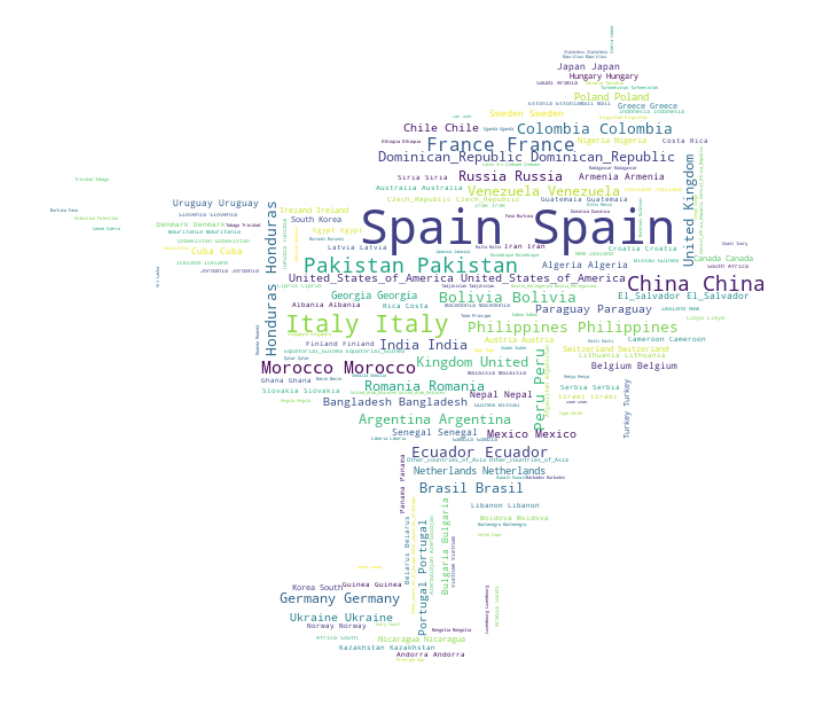

In [13]:
text = ''
for index, row in bcn_top_nationalities_df.iterrows():
    text += int(row['Number']) * (row['Nationality'] + ' ')
        
# save mask to alice_mask
maskfilename = 'outputs/masks/barcelona/barcelona.png'
bcn_mask = np.array(Image.open(maskfilename))

# instantiate a word cloud object    
bcn_wc = WordCloud(background_color='white',max_words=2000000, mask = bcn_mask)

# generate the word cloud
bcn_wc.generate(text)

#Resize the cloud so that we can see the less frequent words a little better.
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

# display the word cloud
plt.imshow(bcn_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

wcfilename = 'outputs/wordclouds/barcelona/barcelona.png'
bcn_wc.to_file(wcfilename)

Create a helper function to create folium maps for main incoming groups

In [15]:
bcn_onehot_nationalities_normpct = bcn_onehot_nationalities_norm.copy()
country_columns = list(bcn_onehot_nationalities_norm.columns[5:])
for country_column in country_columns:
    bcn_onehot_nationalities_normpct[country_column] = bcn_onehot_nationalities_norm[country_column].multiply(100)
bcn_onehot_nationalities_normpct.head()

,C_Dist,N_Dist,C_Neigh,N_Neigh,Number,Afganistan,Albania,Algeria,Andorra,Angola,...,United Kingdom,United_Arab_Emirates,United_States_of_America,Uruguay,Uzbekistan,Venezuela,Vietnam,Yemen,Zambia,Zimbawe
0,01,Ciutat Vella,01,el Raval,47608.0,0.088220,0.023105,0.361284,0.016804,0.008402,...,0.913712,0.000000,0.457906,0.077718,0.006301,0.367585,0.010502,0.0021,0.0,0.000000
1,01,Ciutat Vella,02,el Barri Gotic,16062.0,0.012452,0.056033,0.323745,0.000000,0.000000,...,2.154153,0.006226,1.170464,0.136969,0.018678,0.641265,0.024903,0.0000,0.0,0.006226
2,01,Ciutat Vella,03,la Barceloneta,14996.0,0.000000,0.066684,0.353428,0.000000,0.000000,...,1.433716,0.000000,0.666844,0.193385,0.006668,0.680181,0.013337,0.0000,0.0,0.000000
3,01,Ciutat Vella,04,"Sant Pere, Santa Caterina i la Ribera",22721.0,0.008802,0.030809,0.440121,0.008802,0.000000,...,2.403063,0.000000,1.104705,0.211258,0.017605,0.567757,0.022006,0.0000,0.0,0.004401
4,02,Eixample,05,el Fort Pienc,32016.0,0.000000,0.021864,0.078086,0.012494,0.006247,...,0.584083,0.000000,0.312344,0.134308,0.000000,0.615317,0.003123,0.0000,0.0,0.000000


In [26]:
def create_map(table, neigh, mapped_feature, add_text = ''):
    
    bcn_geo = processed_neighbourhood_jsonfile # geojson file
    
    # Barcelona latitude and longitude values
    latitude = 41.396
    longitude = 2.1774322

    # create map and display it
    bcn_map = folium.Map(location=[latitude, longitude], zoom_start=12)
  
    # generate choropleth map using the average housing price per square meter in 2018
    folium.Choropleth(
        geo_data=bcn_geo,
        data=table,
        columns=[neigh, mapped_feature],
        key_on='feature.properties.C_Neigh',
        fill_color='YlOrRd', 
        fill_opacity=0.7, 
        line_opacity=0.2,
        overlay = True,
        #threshold_scale=threshold_scale,
        legend_name='Percentage of citizens from ' + (' ').join(mapped_feature.split('_')).title() + ' ' + add_text + 'across Barcelona'
    ).add_to(bcn_map)
    
    folium.LayerControl().add_to(bcn_map)
  
    #save the map 
    delay=5
    fn= outfile = 'outputs/maps/top_nationalities/' + mapped_feature + '_map.html'
    tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
    bcn_map.save(fn)

    browser = webdriver.Chrome()
    browser.set_window_size(860, 750)
    browser.get(tmpurl)
    #Give the map tiles some time to load
    time.sleep(delay)
    browser.save_screenshot('outputs/maps/top_nationalities/' + mapped_feature + '_map.png')
    browser.quit()

In [27]:
create_map(bcn_onehot_nationalities_normpct,'C_Neigh','Spain')
create_map(bcn_onehot_nationalities_normpct,'C_Neigh','Italy')
create_map(bcn_onehot_nationalities_normpct,'C_Neigh','China')
create_map(bcn_onehot_nationalities_normpct,'C_Neigh','Pakistan')
create_map(bcn_onehot_nationalities_normpct,'C_Neigh','France')
create_map(bcn_onehot_nationalities_normpct,'C_Neigh','Pakistan')
create_map(bcn_onehot_nationalities_normpct,'C_Neigh','Morocco')
create_map(bcn_onehot_nationalities_normpct,'C_Neigh','Philippines')
create_map(bcn_onehot_nationalities_normpct,'C_Neigh','Bolivia')
create_map(bcn_onehot_nationalities_normpct,'C_Neigh','Colombia')
create_map(bcn_onehot_nationalities_normpct,'C_Neigh','Peru')
create_map(bcn_onehot_nationalities_normpct,'C_Neigh','Ecuador')
create_map(bcn_onehot_nationalities_normpct,'C_Neigh','Honduras')
create_map(bcn_onehot_nationalities_normpct,'C_Neigh','United Kingdom')
create_map(bcn_onehot_nationalities_normpct,'C_Neigh','Romania')
create_map(bcn_onehot_nationalities_normpct,'C_Neigh','Russia')

#### Neighbourhood analysys

In [ ]:
bcn_onehot_nationalities.head(50)

In [ ]:
country_columns = list(bcn_onehot_nationalities.columns[6:])

for index, row in bcn_onehot_nationalities.iterrows():
    text = ''
    for country_column in country_columns:
        text += int(row[country_column]) * (country_column + ' ')
        
    # save mask to alice_mask
    maskfilename = 'outputs/masks/neighbourhoods/' + row['C_Neigh'] + "-" + row['N_Neigh']  + ".png"
    neighbourhood_mask = np.array(Image.open(maskfilename))
    
    # instantiate a word cloud object    
    neighbourhood_wc = WordCloud(background_color='white',max_words=2000000, mask=neighbourhood_mask)

    # generate the word cloud
    neighbourhood_wc.generate(text)
     
    #Resize the cloud so that we can see the less frequent words a little better.
    fig = plt.figure()
    fig.set_figwidth(14) # set width
    fig.set_figheight(18) # set height
    
    # display the word cloud
    plt.imshow(neighbourhood_wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
    wcfilename = 'outputs/wordclouds/neighbourhoods/' + row['C_Neigh'] + "-" + row['N_Neigh']  + ".png"
    neighbourhood_wc.to_file(wcfilename)

#### Clustering

This metric can be mean, distance between data points and their cluster's centroid. Which indicate how dense our clusters are or, to what extent we minimize the error of clustering. Then, looking at the change of this metric, we can find the best value for K. But the problem is that with increasing the number of clusters, the distance of centroids to data points will always reduce. This means increasing K will always decrease the error. So, the value of the metric as a function of K is plotted and the elbow point is determined where the rate of decrease sharply shifts. It is the right K for clustering. This method is called the elbow method

In [ ]:
bcn_onehot_nationalities_clustering = bcn_onehot_nationalities_norm.drop(['C_Dist','N_Dist','C_Neigh','N_Neigh','Number'],1)

# clustering dataset
# determine k using elbow method

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k,random_state=0).fit(bcn_onehot_nationalities_clustering)
    #distortions.append(sum(np.min(cdist(bcn_grouped_4sq_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / bcn_grouped_4sq_clustering.shape[0])
    distortions.append(kmeanModel.inertia_)
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.savefig('outputs/clustering/elbow_clustering_nationalities.png')
plt.show() 

In [ ]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeanModel = KMeans(n_clusters=kclusters, random_state=0).fit(bcn_onehot_nationalities_clustering)

# check cluster labels generated for each row in the dataframe
kmeanModel.labels_

In [ ]:
# compute the distances:
dists = euclidean_distances(kmeanModel.cluster_centers_)
dists

In [ ]:
#you'll only want to compute on the upper (or lower) triangular corner of the distance matrix:
tri_dists = dists[np.triu_indices(kclusters, 1)]
max_dist, avg_dist, min_dist = tri_dists.max(), tri_dists.mean(), tri_dists.min()
print(max_dist)
print(avg_dist)
print(min_dist)

In [ ]:
# add clustering labels
clusterLabels = np.where(kmeanModel.labels_==1, 3, kmeanModel.labels_)
clusterLabels = np.where(clusterLabels==2, 1, clusterLabels)
clusterLabels = np.where(clusterLabels==3, 2, clusterLabels)
clusterLabels
bcn_onehot_nationalities_norm.insert(0, 'Cluster Labels', clusterLabels)
bcn_onehot_nationalities.insert(0, 'Cluster Labels', clusterLabels)

In [ ]:
#https://github.com/WarioDoor/Coursera_Capstone/blob/master/Barcellona%20Barrios%20Foursquare.ipynb
neigh_list= []
for row in geojson ['features']:
    row['C_Neigh']= row['properties']['C_Neigh']
        if isinstance(coords[0], (list)):
            print(row['C_Neigh'],'List')
        else:
            for coords in row['geometry']['coordinates'][0]:
            x, y = coords[0], coords[1]
            px = int(iwidth - image_padding - ((maxX - x) * xratio))
            py = int(image_padding + (maxY - y) * yratio)
            pixels.append((px,py)) 
            
            pixels.append((px,py))  

In [ ]:
neigh_list= []
for row in geojson ['features']:
    barrio_poly= {}
    row['C_Neigh']= row['properties']['C_Neigh']
    x,y = row['geometry']['coordinates'][0][0]
    print(x,y)

In [ ]:
bcn_onehot_nationalities_clustergroup = bcn_onehot_nationalities.groupby(['Cluster Labels']).sum().reset_index()
bcn_onehot_nationalities_clustergroup

In [ ]:
country_columns = list(bcn_onehot_nationalities_clustergroup.columns[3:])

for index, row in bcn_onehot_nationalities_clustergroup.iterrows():
    text = ''
    for country_column in country_columns:
        text += int(row[country_column]) * (country_column + ' ')
        
    # save mask to alice_mask
    #maskfilename = 'masks/Cluster-' + row['Cluster Labels'] + ".png"
    #neighbourhood_mask = np.array(Image.open(maskfilename))
    
    # instantiate a word cloud object    
    #neighbourhood_wc = WordCloud(background_color='white',max_words=2000000, mask=neighbourhood_mask)
    neighbourhood_wc = WordCloud(background_color='white',max_words=2000000)

    # generate the word cloud
    neighbourhood_wc.generate(text)
     
    #Resize the cloud so that we can see the less frequent words a little better.
    fig = plt.figure()
    fig.set_figwidth(14) # set width
    fig.set_figheight(18) # set height
    
    # display the word cloud
    plt.imshow(neighbourhood_wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
    wcfilename = 'outputs/wordclouds/clusters/Cluster-' + str(row['Cluster Labels']) + ".png"
    neighbourhood_wc.to_file(wcfilename)

<b> Visualize clusters obtainedI</b>

xxx

In [ ]:
bcn_onehot_nationalities.head()

In [ ]:
bcn_geo = processed_neighbourhood_jsonfile # geojson file

# Barcelona latitude and longitude values
latitude = 41.396
longitude = 2.1774322

# create map and display it
bcn_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# generate choropleth map using the average housing price per square meter in 2018
folium.Choropleth(
    geo_data=bcn_geo,
    data=bcn_onehot_nationalities,
    columns=['C_Neigh', 'Cluster Labels'],
    key_on='feature.properties.C_Neigh',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Neighbourhood clusters according to nationality population'
    overlay = True,
).add_to(bcn_map)

folium.LayerControl().add_to(bcn_map)

#save the map 
delay=5
fn= outfile = 'outputs/maps/clusters/bcn_neighbourhood_clusters.html'
tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
bcn_map.save(fn)

browser = webdriver.Chrome()
browser.set_window_size(860, 750)
browser.get(tmpurl)
#Give the map tiles some time to load
time.sleep(delay)
browser.save_screenshot('outputs/maps/clusters/bcn_neighbourhood_clusters.png')
browser.quit()

# display map
bcn_map